In [1]:
#NEW IDEA. PERHAPS FOR EACH FIGHT, WE LOOK AT THE CORRESPONDING POINT IN THE SPACE OF ALL FEATURES, AND THEN
#BUILD A MODEL WHERE THE TRAINING SET ONLY INVOLVES POINTS NEAR THAT POINT.
#THIS MIGHT BE MORE EFFECTIVE BECAUSE THE MOST RELEVANT FEATURES IS LIKELY TO DEPEND ON THE LOCATION
#IN THE PARAMETER SPACE.

In [2]:
#needed after restructuring of directory
import os
os.chdir('/Users/alexchandler/UFC_Prediction_2022')
os.getcwd()

'/Users/alexchandler/UFC_Prediction_2022'

In [3]:
#getting dependencies
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' (disables SettingWithCopyWarning)

import numpy as npy
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import random
import sklearn
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
import itertools
#this imports all of the functions from the file functions.py
os.chdir('/Users/alexchandler/UFC_Prediction_2022/src')
from functions import *
os.chdir('/Users/alexchandler/UFC_Prediction_2022')

In [4]:
#importing csv fight data and saving as dataframes
ufc_fights_winner = pd.read_csv('src/models/buildingMLModel/data/processed/ufc_fights.csv',low_memory=False)
ufc_fights_method = pd.read_csv('src/models/buildingMLModel/data/processed/ufc_fights.csv',low_memory=False)
ufcfighterscrap =pd.read_csv('src/models/buildingMLModel/data/processed/fighter_stats.csv',sep=',',low_memory=False)

In [5]:
#cleaning the methods column for winner prediction 
#changing anything other than 'U-DEC','M-DEC', 'KO/TKO', 'SUB', to 'bullshit'
#changing 'U-DEC','M-DEC', to 'DEC'
#(counting split decisions as bullshit)
ufc_fights_winner['method'] = clean_method_for_winner_vect(ufc_fights_winner['method'])
ufc_fights_winner['method'].unique()

array(['SUB', 'DEC', 'KO/TKO', 'bullshit'], dtype=object)

In [6]:
#cleaning the methods column for method prediction 
#changing anything other than 'U-DEC','M-DEC', 'S-DEC', 'KO/TKO', 'SUB', to 'bullshit'
#changing 'U-DEC','M-DEC', 'S-DEC', to 'DEC'
#(counting split decisions as decisions)
ufc_fights_method['method'] = clean_method_vect(ufc_fights_method['method'])
ufc_fights_method['method'].unique()

array(['SUB', 'DEC', 'KO/TKO', 'bullshit'], dtype=object)

In [7]:
#getting rid of rows with incomplete or useless data
#fights with outcome "Win" or "Loss" (no "Draw")
draw_mask=ufc_fights_winner['result'] != 'D' 
#fights where the method of victory is TKO/SUB/DEC (no split decision or DQ or Overturned or anything else like that)
method_mask_winner=(ufc_fights_winner['method']!='bullshit')
method_mask_method=(ufc_fights_method['method']!='bullshit')
#fights where age is known
age_mask=(ufc_fights_winner['fighter_age']!='unknown')&(ufc_fights_winner['opponent_age']!='unknown')
#fights where height reach is known
height_mask=(ufc_fights_winner['fighter_height']!='unknown')&(ufc_fights_winner['opponent_height']!='unknown')
reach_mask=(ufc_fights_winner['fighter_reach']!='unknown')&(ufc_fights_winner['opponent_reach']!='unknown')
#fights where number of wins is known
wins_mask=(ufc_fights_winner['fighter_wins'] != 'unknown' )& (ufc_fights_winner['opponent_wins'] != 'unknown')
#fights where both fighters have strike statistics (gets rid of UFC debuts)
strikes_mask=(ufc_fights_winner['fighter_inf_sig_strikes_attempts_avg'] != 0)&(ufc_fights_winner['opponent_inf_sig_strikes_attempts_avg'] != 0)
#includes only the fights satisfying these conditions
ufc_fights_winner=ufc_fights_winner[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights_method=ufc_fights_method[draw_mask&method_mask_method&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]
ufc_fights=ufc_fights[draw_mask&method_mask_winner&age_mask&height_mask&reach_mask&wins_mask&strikes_mask]

#listing all stats and making some new stats from them (differences often score higher in the learning models)
record_statistics=[u'fighter_wins', 
                   u'fighter_losses',
                   u'fighter_L5Y_wins',
                   u'fighter_L5Y_losses', 
                   u'fighter_L2Y_wins', 
                   u'fighter_L2Y_losses',
                    u'fighter_ko_wins',
                   u'fighter_ko_losses',
                   u'fighter_L5Y_ko_wins',
                   u'fighter_L5Y_ko_losses',
                   u'fighter_L2Y_ko_wins',
                    u'fighter_L2Y_ko_losses',
                   u'fighter_sub_wins',
                   u'fighter_sub_losses',
                   u'fighter_L5Y_sub_wins',
                    u'fighter_L5Y_sub_losses', 
                   u'fighter_L2Y_sub_wins', 
                   u'fighter_L2Y_sub_losses',
                   u'opponent_wins', 
                   u'opponent_losses',
                   u'opponent_L5Y_wins', 
                   u'opponent_L5Y_losses', 
                   u'opponent_L2Y_wins', 
                   u'opponent_L2Y_losses', 
                    u'opponent_ko_wins', 
                   u'opponent_ko_losses', 
                   u'opponent_L5Y_ko_wins', 
                   u'opponent_L5Y_ko_losses', 
                   u'opponent_L2Y_ko_wins',
                    u'opponent_L2Y_ko_losses', 
                   u'opponent_sub_wins', 
                   u'opponent_sub_losses',
                   u'opponent_L5Y_sub_wins', 
                    u'opponent_L5Y_sub_losses', 
                   u'opponent_L2Y_sub_wins', 
                   u'opponent_L2Y_sub_losses']

physical_stats=[ u'fighter_age',
                u'fighter_height',
                    u'fighter_reach',  
                u'opponent_age',  
                u'opponent_height',
                    u'opponent_reach']

#THERE MAY BE A PROBLEM IN AGE HEIGHT REACH TO DO WITH STRING VS FLOAT. MAKE SURE THESE ARE ALL THE CORRECT TYPE
#MAYBE WE ARE LOSING PREDICTABILITY HERE

#here is the list of all stats available (besides stance), does not include names or result
punch_statistics=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                    
                    u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg']

#here is the version of punch stats geared for comparing fighter_inf to opponent_abs
punch_statistics_alt=[    u'fighter_inf_knockdowns_avg',
                    u'fighter_inf_pass_avg',
                    u'fighter_inf_reversals_avg',
                    u'fighter_inf_sub_attempts_avg',
                    u'fighter_inf_takedowns_landed_avg',
                    u'fighter_inf_takedowns_attempts_avg',
                    u'fighter_inf_sig_strikes_landed_avg',
                    u'fighter_inf_sig_strikes_attempts_avg',
                    u'fighter_inf_total_strikes_landed_avg',
                    u'fighter_inf_total_strikes_attempts_avg',
                    u'fighter_inf_head_strikes_landed_avg',
                    u'fighter_inf_head_strikes_attempts_avg',
                    u'fighter_inf_body_strikes_landed_avg',
                    u'fighter_inf_body_strikes_attempts_avg',
                    u'fighter_inf_leg_strikes_landed_avg',
                    u'fighter_inf_leg_strikes_attempts_avg',
                    u'fighter_inf_distance_strikes_landed_avg',
                    u'fighter_inf_distance_strikes_attempts_avg',
                    u'fighter_inf_clinch_strikes_landed_avg',
                    u'fighter_inf_clinch_strikes_attempts_avg',
                    u'fighter_inf_ground_strikes_landed_avg',
                    u'fighter_inf_ground_strikes_attempts_avg',
                
                    u'fighter_abs_knockdowns_avg',
                    u'fighter_abs_pass_avg',
                    u'fighter_abs_reversals_avg',
                    u'fighter_abs_sub_attempts_avg',
                    u'fighter_abs_takedowns_landed_avg',
                    u'fighter_abs_takedowns_attempts_avg',
                    u'fighter_abs_sig_strikes_landed_avg',
                    u'fighter_abs_sig_strikes_attempts_avg',
                    u'fighter_abs_total_strikes_landed_avg',
                    u'fighter_abs_total_strikes_attempts_avg',
                    u'fighter_abs_head_strikes_landed_avg',
                    u'fighter_abs_head_strikes_attempts_avg',
                    u'fighter_abs_body_strikes_landed_avg',
                    u'fighter_abs_body_strikes_attempts_avg',
                    u'fighter_abs_leg_strikes_landed_avg',
                    u'fighter_abs_leg_strikes_attempts_avg',
                    u'fighter_abs_distance_strikes_landed_avg',
                    u'fighter_abs_distance_strikes_attempts_avg',
                    u'fighter_abs_clinch_strikes_landed_avg',
                    u'fighter_abs_clinch_strikes_attempts_avg',
                    u'fighter_abs_ground_strikes_landed_avg',
                    u'fighter_abs_ground_strikes_attempts_avg',
                
                    u'opponent_abs_knockdowns_avg',
                    u'opponent_abs_pass_avg',
                    u'opponent_abs_reversals_avg',
                    u'opponent_abs_sub_attempts_avg',
                    u'opponent_abs_takedowns_landed_avg',
                    u'opponent_abs_takedowns_attempts_avg',
                    u'opponent_abs_sig_strikes_landed_avg',
                    u'opponent_abs_sig_strikes_attempts_avg',
                    u'opponent_abs_total_strikes_landed_avg',
                    u'opponent_abs_total_strikes_attempts_avg',
                    u'opponent_abs_head_strikes_landed_avg',
                    u'opponent_abs_head_strikes_attempts_avg',
                    u'opponent_abs_body_strikes_landed_avg',
                    u'opponent_abs_body_strikes_attempts_avg',
                    u'opponent_abs_leg_strikes_landed_avg',
                    u'opponent_abs_leg_strikes_attempts_avg',
                    u'opponent_abs_distance_strikes_landed_avg',
                    u'opponent_abs_distance_strikes_attempts_avg',
                    u'opponent_abs_clinch_strikes_landed_avg',
                    u'opponent_abs_clinch_strikes_attempts_avg',
                    u'opponent_abs_ground_strikes_landed_avg',
                    u'opponent_abs_ground_strikes_attempts_avg',
                     
                     u'opponent_inf_knockdowns_avg',
                    u'opponent_inf_pass_avg',
                    u'opponent_inf_reversals_avg',
                    u'opponent_inf_sub_attempts_avg',
                    u'opponent_inf_takedowns_landed_avg',
                    u'opponent_inf_takedowns_attempts_avg',
                    u'opponent_inf_sig_strikes_landed_avg',
                    u'opponent_inf_sig_strikes_attempts_avg',
                    u'opponent_inf_total_strikes_landed_avg',
                    u'opponent_inf_total_strikes_attempts_avg',
                    u'opponent_inf_head_strikes_landed_avg',
                    u'opponent_inf_head_strikes_attempts_avg',
                    u'opponent_inf_body_strikes_landed_avg',
                    u'opponent_inf_body_strikes_attempts_avg',
                    u'opponent_inf_leg_strikes_landed_avg',
                    u'opponent_inf_leg_strikes_attempts_avg',
                    u'opponent_inf_distance_strikes_landed_avg',
                    u'opponent_inf_distance_strikes_attempts_avg',
                    u'opponent_inf_clinch_strikes_landed_avg',
                    u'opponent_inf_clinch_strikes_attempts_avg',
                    u'opponent_inf_ground_strikes_landed_avg',
                    u'opponent_inf_ground_strikes_attempts_avg']

#adding record differences to ufc_fights
record_statistics_diff = []
half_length=int(len(record_statistics)/2)
for i in range(half_length):
    ufc_fights_winner[record_statistics[i]+'_diff_2']=ufc_fights_winner[record_statistics[i]]-ufc_fights_winner[record_statistics[i+half_length]]
    ufc_fights_method[record_statistics[i]+'_diff_2']=ufc_fights_method[record_statistics[i]]-ufc_fights_method[record_statistics[i+half_length]]
    record_statistics_diff.append(record_statistics[i]+'_diff_2')
    
#lets try and improve the greedy algorithm by considering differences. Lets start by replacing height and reach by their differences
ufc_fights_winner['height_diff']=ufc_fights_winner['fighter_height'].apply(float)-ufc_fights_winner['opponent_height'].apply(float)
ufc_fights_winner['reach_diff']=ufc_fights_winner['fighter_reach'].apply(float)-ufc_fights_winner['opponent_reach'].apply(float)
ufc_fights_method['height_diff']=ufc_fights_method['fighter_height'].apply(float)-ufc_fights_method['opponent_height'].apply(float)
ufc_fights_method['reach_diff']=ufc_fights_method['fighter_reach'].apply(float)-ufc_fights_method['opponent_reach'].apply(float)


physical_stats_diff = ['fighter_age_diff', 'height_diff', 'reach_diff']

#adding punch differences to ufc_fights
punch_statistics_diff = []
half_length=int(len(punch_statistics)/2)
for i in range(half_length):
    ufc_fights_method[punch_statistics[i]+'_diff_2']=ufc_fights_method[punch_statistics[i]]-ufc_fights_method[punch_statistics[i+half_length]]
    ufc_fights_winner[punch_statistics[i]+'_diff_2']=ufc_fights_winner[punch_statistics[i]]-ufc_fights_winner[punch_statistics[i+half_length]]
    punch_statistics_diff.append(punch_statistics[i]+'_diff_2')
    
possible_stats =record_statistics_diff+physical_stats_diff+punch_statistics_diff

#setting age to float
ufc_fights_winner['fighter_age'] = ufc_fights_winner['fighter_age'].apply(float)
ufc_fights_winner['opponent_age'] = ufc_fights_winner['opponent_age'].apply(float)
ufc_fights_method['fighter_age'] = ufc_fights_method['fighter_age'].apply(float)
ufc_fights_method['opponent_age'] = ufc_fights_method['opponent_age'].apply(float)
ufc_fights_winner['fighter_age_diff'] = ufc_fights_winner['fighter_age']-ufc_fights_winner['opponent_age']

ufc_fights_winner['fighter_age_diff_adj'] = (ufc_fights_winner['fighter_age']-23).apply(abs)-(ufc_fights_winner['opponent_age']-23).apply(abs)



In [8]:
ufc_fights_winner['fighter_age'].unique()

array([34., 26., 27., 30., 32., 37., 28., 36., 31., 29., 35., 39., 24.,
       44., 33., 25., 38., 41., 42., 43., 40., 23., 22., 20., 21., 46.,
       45., 19., 47.])

In [9]:
ufc_fights_method['method'].unique()

array(['SUB', 'DEC', 'KO/TKO'], dtype=object)

In [10]:
ufc_fights_method['result'].unique()

array(['L', 'W'], dtype=object)

In [11]:
ufc_fights_winner['method'].unique()

array(['SUB', 'DEC', 'KO/TKO'], dtype=object)

In [12]:
ufc_fights_winner['result'].unique()

array(['L', 'W'], dtype=object)

In [13]:
ufc_fights['result'].unique()

array(['L', 'W'], dtype=object)

In [14]:
#shows all unique ages as float
ages = ufc_fights_winner['fighter_age'].unique()
ages.sort()
ages

array([19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31.,
       32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
       45., 46., 47.])

In [15]:
#this is currently the highest scoring subset of stats to choose. It scores around .637. 
#dropped to ,.617 after I changed the age columns to be floats instead of strings... this is VERY strange...
#actually, after I changed method mask to coincide with the method prediction notebook, it dropped a whole percentage
#to .626... Why would this be?
#FIGURED IT OUT. Including split decisions in the example set drops predictions by a whole percentage. I changed the
#clean_method function to count split decisions as 'bullshit'
#This is the score to beat.

best_smallest_set=list(set(['fighter_age_diff', 
                            'reach_diff', 
                            'fighter_L5Y_ko_losses_diff_2', 
                            'fighter_L5Y_losses_diff_2', 
                            'fighter_L2Y_wins_diff_2', 
                            'fighter_L5Y_wins_diff_2', 
                            'fighter_L5Y_sub_wins_diff_2', 
                            'fighter_abs_total_strikes_landed_avg_diff_2', 
                            'fighter_inf_head_strikes_landed_avg_diff_2', 
                            'fighter_inf_leg_strikes_landed_avg_diff_2', 
                            'fighter_abs_head_strikes_landed_avg_diff_2', 
                            'fighter_inf_knockdowns_avg_diff_2', 
                            'fighter_inf_clinch_strikes_attempts_avg_diff_2', 
                            'fighter_inf_takedowns_attempts_avg_diff_2', 
                            'fighter_inf_ground_strikes_landed_avg_diff_2', 
                            'fighter_inf_sig_strikes_landed_avg_diff_2'
]))

ufc_fights_df = ufc_fights_winner[best_smallest_set]

winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000, fit_intercept=False)
X=ufc_fights_df.iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
winPredictionModel.fit(X,y)
print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(cross_val_score(winPredictionModel,X,y,cv=3).mean()))



model score: 0.6363636363636364
cross val score: 0.6240909603448682


In [16]:
# current best cross val score is at .642 with ['fighter_age_diff','4-fighter_score_diff','fighter_abs_total_strikes_landed_avg_diff_2','fighter_inf_sub_attempts_avg_diff_2_alt','fighter_inf_sig_strikes_landed_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','1-fight_math','fighter_inf_body_strikes_attempts_avg_diff_2_alt','fighter_inf_total_strikes_attempts_avg_diff_2','fighter_abs_body_strikes_landed_avg_diff_2','fighter_L2Y_sub_wins_diff_2_alt','fighter_ko_wins_diff_2_alt']
    
current_best = ['fighter_age_diff',
 'fighter_L5Y_losses_diff_2',
 'fighter_age_diff_adj',
 'fighter_abs_sig_strikes_attempts_avg_diff_2',
 'fighter_ko_losses_diff_2',
 'fighter_losses_diff_2',
 'fighter_L2Y_ko_wins_diff_2',
 'fighter_abs_leg_strikes_landed_avg_diff_2',
 '1-fight_math',
 'fighter_abs_sig_strikes_landed_avg_diff_2',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 '4-fighter_score_diff',
 'fighter_abs_pass_avg_diff_2']

y=ufc_fights_winner['result'].iloc[0:40*75]
X=ufc_fights_winner[current_best].iloc[0:40*75]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000, fit_intercept=False)
winPredictionModel.fit(X,y)

print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(cross_val_score(winPredictionModel,X,y,cv=4).mean()))

model score: 0.6366666666666667
cross val score: 0.6343333333333333


In [17]:
#using 4 at a time to run greedy, found this 4 stat combo giving .638 cross val score with fit_intercept = False
current_best = ['fighter_age_diff', 
                '4-fighter_score_diff', 
                'fighter_abs_distance_strikes_attempts_avg_diff_2', 
                'fighter_abs_total_strikes_landed_avg_diff_2']
ufc_fights_df = ufc_fights_winner[current_best]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000,fit_intercept=False)
X=ufc_fights_df.iloc[0:2080].to_numpy()
y=ufc_fights_winner['result'].iloc[0:2080]
winPredictionModel.fit(X,y)
print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(cross_val_score(winPredictionModel,X,y,cv=3).mean()))

model score: 0.6326923076923077
cross val score: 0.6307739117537389


In [18]:
winPredictionModel.intercept_

array([0.])

In [ ]:
#HERE WE START SOME UNNECESSARY STUFF THAT SHOULDN"T RUN

In [ ]:
#NN with a pipeline
#this is overfit because it fixes a specific random state for test_train_split... you have to average over a list
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
scores=[]
for i in range(5,20):
    for j in range(5,20):
        for k in range(1,20):
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
            clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(i,j), random_state=k, max_iter=2000)
            pipe = make_pipeline(StandardScaler(), clf)
            pipe.fit(X_train, y_train)  # apply scaling on training data
            score=pipe.score(X_test, y_test)
            scores.append([i,j,k,score])

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
#the highest scoring NN (overfit... see below) (change the random state from 42 and observe)
max([scores[j][3] for j in range(len(scores))])

In [ ]:
#Here is the highest scoring NN model (almost 67%!!!)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(9,13), random_state=11, max_iter=2000)
pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train, y_train)  # apply scaling on training data
print('Accuracy: '+str(pipe.score(X_test, y_test)))

In [ ]:
#but we need to further cross validate this (even though it was trained on a test set...) just to be safe

In [ ]:
#lets take the average over all test_train_split random_states (decrease to .623)
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(9,13), random_state=11, max_iter=2000)
pipe = make_pipeline(StandardScaler(), clf)
scores=[]
for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    pipe.fit(X_train, y_train)  # apply scaling on training data
    scores.append(pipe.score(X_test, y_test))
print('Average Score: '+str(sum(scores)/len(scores)))

In [ ]:
#cross validated NN with a standardscalar-clf pipeline (current best is .636)
#THIS DOES NOT OUTPERFORM LR!!!
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
avscores=[]
for i in range(5,30):
    for j in range(2,20):
        for k in range(1,5):
            scores=[]
            for l in range(1,4):
                X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=l)
                clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(i,j), random_state=k, max_iter=2000)
                pipe = make_pipeline(StandardScaler(), clf)
                pipe.fit(X_train, y_train)  # apply scaling on training data
                score=pipe.score(X_test, y_test)
                scores.append(score)
            avscores.append([i,j,k,sum(scores)/len(scores)])
                
                
                

In [ ]:
maxav=max([avscores[j][3] for j in range(len(avscores))]);maxav

In [ ]:
topscores=[j for j in range(len(avscores)) if avscores[j][3]>maxav-.005];topscores

In [ ]:
for i in range(len(topscores)):
    print(avscores[topscores[i]])

In [ ]:
#trying random forest for winner prediction
#not bad.. may need to redo feature analysis specifically for this
#also try messing with parameters
ufc_fights_df = ufc_fights_winner[current_best]
X=ufc_fights_df.iloc[0:2080].to_numpy()
y=ufc_fights_winner['result'].iloc[0:2080]
rfc=RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y)
rfc=RandomForestClassifier()
pipe = make_pipeline(StandardScaler(), rfc)
pipe.fit(X_train, y_train)  # apply scaling on training data
pipe.score(X_test,y_test)

In [ ]:
#Lets try a NN on the entire dataset (does very poorly...)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X=ufc_fights_winner[possible_stats].iloc[0:40*55].to_numpy()
y=ufc_fights_winner['result'].iloc[0:40*55]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(len(possible_stats),len(possible_stats),), random_state=11, max_iter=5000)
pipe = make_pipeline(StandardScaler(), clf)
pipe.fit(X_train, y_train)  # apply scaling on training data
print('Accuracy: '+str(pipe.score(X_test, y_test)))

In [ ]:
#random forest does way better for picking the method!
best_stats=['fighter_ko_losses_diff_2', 'fighter_L2Y_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300]
yr=ufc_fights_method['method'].iloc[0:2300]

rfc.fit(Xr,yr)
accuracy = cross_val_score(rfc,Xr,yr,cv=3).mean()
precision = cross_val_score(rfc,Xr,yr,cv=3, scoring='precision_micro').mean()
recall = cross_val_score(rfc, Xr, yr, cv=3, scoring='recall_macro').mean()
print('Accuracy: '+str(accuracy),'F1 score: '+str(precision*recall/(precision+recall)))

In [ ]:
#BACK TO THE GOOD STUFF

In [19]:
#I've defined this in such a way to predict what happens when fighter1 in their day1 version fights fighter2
#in their day2 version. Meaning we could compare for example 2014 Tyron Woodley to 2019 Colby Covington
def ufc_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [fighter_score_diff(fighter1,fighter2,day1, 4),
            fighter_score_diff(fighter1,fighter2,day1, 9),
            fighter_score_diff(fighter1,fighter2,day1, 15),
            fight_math_diff(fighter1,fighter2,day1, 1),
            fight_math_diff(fighter1,fighter2,day1, 6),
            L5Y_sub_wins(fighter1,day1)-L5Y_sub_wins(fighter2,day2),
            L5Y_losses(fighter1,day1)-L5Y_losses(fighter2,day2),
            L5Y_ko_losses(fighter1,day1)-L5Y_ko_losses(fighter2,day2),
            fighter_age(fighter1,day1)-fighter_age(fighter2,day2),
            avg_count('total_strikes_landed',fighter1,'abs',day1)-avg_count('total_strikes_landed',fighter2,'abs',day2),
            avg_count('head_strikes_landed',fighter1,'abs',day1)-avg_count('head_strikes_landed',fighter2,'abs',day2),
            avg_count('ground_strikes_landed',fighter1,'inf',day1)-avg_count('ground_strikes_landed',fighter2,'inf',day2),
            avg_count('takedowns_attempts',fighter1,'inf',day1)-avg_count('takedowns_attempts',fighter2,'inf',day2),
            avg_count('head_strikes_landed',fighter1,'inf',day1)-avg_count('head_strikes_landed',fighter2,'inf',day2),
           ]


def ufc_method_prediction_tuple(fighter1,fighter2,day1=date.today(),day2=date.today()):
    return [ko_losses(fighter1,day1)-ko_losses(fighter2,day2),
            sub_losses(fighter1,day1)-sub_losses(fighter2,day2)]

#improvement after adding fight math stats
current_best = ['4-fighter_score_diff',
 '9-fighter_score_diff',
 '15-fighter_score_diff',
 '1-fight_math',
 '6-fight_math',
 'fighter_L5Y_sub_wins_diff_2',
 'fighter_L5Y_losses_diff_2',
 'fighter_L5Y_ko_losses_diff_2',
 'fighter_age_diff',
 'fighter_abs_total_strikes_landed_avg_diff_2',
 'fighter_abs_head_strikes_landed_avg_diff_2',
 'fighter_inf_ground_strikes_landed_avg_diff_2',
 'fighter_inf_takedowns_attempts_avg_diff_2',
 'fighter_inf_head_strikes_landed_avg_diff_2',
 ]

ufc_fights_df = ufc_fights_winner[current_best]
winPredictionModel=LogisticRegression(solver='lbfgs', max_iter=2000, fit_intercept=False)
X=ufc_fights_df.iloc[0:2080].to_numpy()
y=ufc_fights_winner['result'].iloc[0:2080]
winPredictionModel.fit(X,y)
print('model score: '+str(winPredictionModel.score(X,y)))
print('cross val score: '+str(cross_val_score(winPredictionModel,X,y,cv=3).mean()))
print('coefficients'+str(winPredictionModel.coef_))
print('intercept'+str(winPredictionModel.intercept_))

best_stats=['fighter_ko_losses_diff_2', 'fighter_sub_losses_diff_2']
rfc=RandomForestClassifier()
Xr=ufc_fights_method[best_stats].iloc[0:2300].to_numpy()
yr=ufc_fights_method['method'].iloc[0:2300]
rfc.fit(Xr,yr)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

#date entered in the form 'Aug 20, 2013'
#predicts what happens if the day1 version of fighter1 fights fighter2 at their day2 version
#by default day1 and day2 are set to today if left unspecified
def ufc_predict(fighter1,fighter2,day1=date.today(), day2=date.today()):
    fighters=[fighter1,fighter2]
    random_guy=fighters[random.choice([0,1])]
    fighter1_fights=(ufcfightscrap['fighter']==fighter1).sum()
    fighter2_fights=(ufcfightscrap['fighter']==fighter2).sum()
    if fighter1_fights==0 and not fighter2_fights==0:
        print('This is '+fighter1+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    elif fighter2_fights==0 and not fighter1_fights==0:
        print('This is '+fighter2+"'s UFC debut... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.') 
    elif fighter1_fights==0 and fighter2_fights==0:
        print('This is both '+fighter1+"'s "+'and '+fighter2+"'s "+"UFC debuts... so obviously I do not have enough data to make an educated pick. But since you are DEMANDING an outcome, hmmm... I guess I'll go with "+random_guy+'.')
    else:
        try:
            print('The winner is...')
            ufc_tuple=ufc_prediction_tuple(fighter1,fighter2,day1,day2)
            ufc_method_tuple=ufc_method_prediction_tuple(fighter1,fighter2,day1,day2)
            value=winPredictionModel.predict([ufc_tuple])[0]
            result=rfc.predict([ufc_method_tuple])[0]
            if fighter1=="Jon Jones" and fighter2=="Jon Jones":
                print('Daniel Cormier')
            elif value=='W':
                print(fighter1+' by '+result)
            else:
                print(fighter2+' by '+result)
            try:
                fighter1stripped = fighter1.replace(" ","")
                fighter2stripped = fighter2.replace(" ","")
                j=random.randrange(1,5)
                img1 = mpimg.imread('images/'+str(j)+fighter1stripped+'.jpg')
                j=random.randrange(1,5)
                img2 = mpimg.imread('images/'+str(j)+fighter2stripped+'.jpg')
                fig, ax = plt.subplots(1, 2, figsize=(10,10))
                ax[0].set(title=fighter1, aspect=1, xticks=[], yticks=[])                
                imgplot = ax[0].imshow(img1)
                ax[1].set(title=fighter2, aspect=1, xticks=[], yticks=[])
                imgplot = ax[1].imshow(img2)
            except FileNotFoundError:
                print('That picture is not in the database somehow...')
        except ValueError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')
        except TypeError:
            print('Fighters have incomplete data on record... or maybe there is an issue with one of the fighters names... I honestly do not know what to do with this.')

                
                

model score: 0.6403846153846153
cross val score: 0.6302908320199386
coefficients[[ 0.0313531   0.01096291 -0.0063184   0.74104254  0.11348209  0.02560963
   0.07331541 -0.03736141 -0.07260855 -0.07654154 -0.01093674  0.0046399
   0.54934939  0.05131937]]
intercept[0.]


In [20]:
theta = winPredictionModel.coef_
theta[0]

array([ 0.0313531 ,  0.01096291, -0.0063184 ,  0.74104254,  0.11348209,
        0.02560963,  0.07331541, -0.03736141, -0.07260855, -0.07654154,
       -0.01093674,  0.0046399 ,  0.54934939,  0.05131937])

In [21]:
# We want to predict how many times out of 10 the winning fighter would win, so we look at the values
# x*theta+b. If the value is >=0 its a win and <=0 its a loss. But how far from zero gives indication of
# how likely the outcome is.
theta = winPredictionModel.coef_
b = winPredictionModel.intercept_[0]

def presigmoid_value(fighter1,fighter2,date1,date2):
    value = 0
    tup = ufc_prediction_tuple(fighter1,fighter2,date1,date2)
    for i in range(len(tup)):
        value += tup[i]*theta[0][i]
    return value + b

import math

def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

#returns the probability that fighter1 defeats fighter2 on date1,date2
def probability(fighter1,fighter2,date1,date2):
    presig=presigmoid_value(fighter1,fighter2,date1,date2)
    return sigmoid(presig)



def manual_prediction(fighter1,fighter2,date1,date2):
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    #value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    return value>=0

In [22]:
def odds(fighter1,fighter2):
    date1=date.today().strftime("%B %d, %Y")
    date2=date.today().strftime("%B %d, %Y")
    p=probability(fighter1,fighter2,date1,date2)
    if p<.5:
        fighterOdds=round(100/p - 100)
        opponentOdds = round(1 / (1 / (1 - p) - 1) * 100)
        return ['+'+str(fighterOdds),'-'+str(opponentOdds)]
    elif p>=.5:
        fighterOdds = round(1 / (1 / p - 1) * 100)
        opponentOdds = round(100 / (1 - p) - 100)
        return ['-'+str(fighterOdds),'+'+str(opponentOdds)]

In [23]:
#now we build prediction_history
#first need to rebuild "same_name" function like we did in js (done)
#next open existing prediction_history.json as a dataframe (done)
#then add all fights on the books from vegas_odds
#for each fight in prediction_history, if a prediction has not yet been made, make a prediction
#then export to json

#first call pip install python-Levenshtein
from Levenshtein import distance as lev
def same_name(str1,str2):
    str1 = str1.lower().replace('.','').replace("-",' ')
    str2 = str2.lower().replace('.','').replace("-",' ')
    str1_list=str1.split()
    str2_list=str2.split()
    str1_set=set(str1_list)
    str2_set=set(str2_list)
    if str1==str2:
        return True
    elif str1_set==str2_set:
        return True
    elif lev(str1,str2)<3:
        return True
    else:
        return False
    
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
vegas_odds=pd.read_json('src/models/buildingMLModel/data/external/vegas_odds.json')

prediction_history=pd.read_json('src/models/buildingMLModel/data/external/prediction_history.json')
def count_null(row_number):
    row = vegas_odds.iloc[row_number]
    return len([i for i in range(len(row)) if row[i]==''])

bookie_mask = []
for i in range(len(vegas_odds['fighter name'])):
    bookie_mask.append(count_null(i)<6)
vegas_odds=vegas_odds[bookie_mask]
vegas_odds_copy=vegas_odds.copy()
for col in ['predicted fighter odds','predicted opponent odds','average bookie odds','correct?']:
    vegas_odds_copy[col]=""

In [64]:
#filling in predictions 
#need to make sure it only makes predictions for fights it hasn't yet predicted
for i in vegas_odds_copy.index:
    fighter=vegas_odds_copy['fighter name'][i]
    opponent=vegas_odds_copy['opponent name'][i]
    odds_calc = odds(fighter,opponent)
    vegas_odds_copy['predicted fighter odds'][i]=odds_calc[0]
    vegas_odds_copy['predicted opponent odds'][i]=odds_calc[1]
    sum_av_f=0
    tot_av_f=0
    sum_av_o=0
    tot_av_o=0
    for bookie in ['DraftKings', 'BetMGM', 'Caesars', 'BetRivers', 'FanDuel', 'PointsBet', 'Unibet', 'Bet365', 'BetWay', '5D', 'Ref']:
        if vegas_odds_copy['fighter '+bookie][i]!='':
            sum_av_f+=int(vegas_odds_copy['fighter '+bookie][i])
            tot_av_f+=1
        if vegas_odds_copy['opponent '+bookie][i]!='':
            sum_av_o+=int(vegas_odds_copy['opponent '+bookie][i])
            tot_av_o+=1
    vegas_odds_copy['average bookie odds'][i]=[str(round(sum_av_f/tot_av_f)),str(round(sum_av_o/tot_av_o))]
vegas_odds_copy
        
        

,fighter name,fighter DraftKings,fighter BetMGM,fighter Caesars,fighter BetRivers,fighter FanDuel,fighter PointsBet,fighter Unibet,fighter Bet365,fighter BetWay,fighter 5D,fighter Ref,opponent name,opponent DraftKings,opponent BetMGM,opponent Caesars,opponent BetRivers,opponent FanDuel,opponent PointsBet,opponent Unibet,opponent Bet365,opponent BetWay,opponent 5D,opponent Ref,predicted fighter odds,predicted opponent odds,average bookie odds,correct?
32,Marlon Vera,+120,+115,+110,+115,+116,+112,+115,+110,+105,+105,+124,Rob Font,-140,-140,-130,-143,-142,-135,-143,-139,-138,-125,-144,-138,+138,"[113, -138]",
35,Gerald Meerschaert,+150,+135,+145,+135,+132,+140,+135,+137,+120,+145,+145,Krzysztof Jotko,-170,-165,-170,-167,-162,-170,-167,-164,-163,-165,-170,+177,-177,"[138, -167]",
36,Andrei Arlovski.,-135,-145,-130,-148,-142,-140,-148,-152,-138,-145,-143,Jake Collier,+115,+120,+110,+115,+116,+116,+115,+125,+105,+125,+123,-1199,+1199,"[-142, 117]",
37,Andre Fili,-275,-275,-270,-286,-280,-270,-286,-333,-275,-250,-250,Joanderson Brito,+220,+210,+220,+215,+220,+215,+215,+250,+200,+210,+210,-161,+161,"[-277, 217]",
38,Darren Elkins,-155,-165,-170,-159,-154,-161,-159,-161,-150,-160,-162,Tristan Connelly,+135,+140,+145,+125,+126,+135,+125,+130,+115,+140,+142,+108,-108,"[-160, 133]",
39,Grant Dawson.,-155,-165,-160,-157,-162,-160,-157,-161,-150,-165,-160,Jared Gordon,+135,+140,+135,+123,+132,+132,+123,+130,+120,+145,+140,-707,+707,"[-159, 132]",
42,Gina Mazany,-160,-185,-170,-159,-176,-170,-159,-175,-163,-165,-174,Shanna Young,+140,+150,+145,+128,+142,+140,+128,+150,+120,+145,+149,-145,+145,"[-169, 140]",
43,Carlos Candelario,+200,+200,+220,+200,+198,+210,+200,+225,+200,+220,+205,Tatsuro Taira,-250,-250,-270,-265,-250,-260,-265,-278,-275,-260,-240,-100,+100,"[207, -260]",
44,Gabriel Green,-150,-155,-150,-150,,-145,-150,-152,-150,-150,-150,Yohan Lainesse,+130,+130,+125,+120,,+120,+120,+125,+115,+130,+130,-100,+100,"[-150, 124]",
45,Mike Breeden,+170,+190,+170,+175,,+170,+175,+187,+163,+170,+163,Natan Levy,-200,-225,-200,-230,,-210,-230,-227,-225,-200,-188,+438,-438,"[173, -214]",


In [69]:
vegas_odds

,fighter name,fighter DraftKings,fighter BetMGM,fighter Caesars,fighter BetRivers,fighter FanDuel,fighter PointsBet,fighter Unibet,fighter Bet365,fighter BetWay,fighter 5D,fighter Ref,opponent name,opponent DraftKings,opponent BetMGM,opponent Caesars,opponent BetRivers,opponent FanDuel,opponent PointsBet,opponent Unibet,opponent Bet365,opponent BetWay,opponent 5D,opponent Ref
32,Marlon Vera,+120,+115,+110,+115,+116,+112,+115,+110,+105,+105,+124,Rob Font,-140,-140,-130,-143,-142,-135,-143,-139,-138,-125,-144
35,Gerald Meerschaert,+150,+135,+145,+135,+132,+140,+135,+137,+120,+145,+145,Krzysztof Jotko,-170,-165,-170,-167,-162,-170,-167,-164,-163,-165,-170
36,Andrei Arlovski.,-135,-145,-130,-148,-142,-140,-148,-152,-138,-145,-143,Jake Collier,+115,+120,+110,+115,+116,+116,+115,+125,+105,+125,+123
37,Andre Fili,-275,-275,-270,-286,-280,-270,-286,-333,-275,-250,-250,Joanderson Brito,+220,+210,+220,+215,+220,+215,+215,+250,+200,+210,+210
38,Darren Elkins,-155,-165,-170,-159,-154,-161,-159,-161,-150,-160,-162,Tristan Connelly,+135,+140,+145,+125,+126,+135,+125,+130,+115,+140,+142
39,Grant Dawson.,-155,-165,-160,-157,-162,-160,-157,-161,-150,-165,-160,Jared Gordon,+135,+140,+135,+123,+132,+132,+123,+130,+120,+145,+140
42,Gina Mazany,-160,-185,-170,-159,-176,-170,-159,-175,-163,-165,-174,Shanna Young,+140,+150,+145,+128,+142,+140,+128,+150,+120,+145,+149
43,Carlos Candelario,+200,+200,+220,+200,+198,+210,+200,+225,+200,+220,+205,Tatsuro Taira,-250,-250,-270,-265,-250,-260,-265,-278,-275,-260,-240
44,Gabriel Green,-150,-155,-150,-150,,-145,-150,-152,-150,-150,-150,Yohan Lainesse,+130,+130,+125,+120,,+120,+120,+125,+115,+130,+130
45,Mike Breeden,+170,+190,+170,+175,,+170,+175,+187,+163,+170,+163,Natan Levy,-200,-225,-200,-230,,-210,-230,-227,-225,-200,-188


In [70]:
prediction_history = pd.concat([vegas_odds_copy, prediction_history], axis = 0).reset_index(drop=True)
prediction_history

,fighter name,fighter DraftKings,fighter BetMGM,fighter Caesars,fighter BetRivers,fighter FanDuel,fighter PointsBet,fighter Unibet,fighter Bet365,fighter BetWay,fighter 5D,fighter Ref,opponent name,opponent DraftKings,opponent BetMGM,opponent Caesars,opponent BetRivers,opponent FanDuel,opponent PointsBet,opponent Unibet,opponent Bet365,opponent BetWay,opponent 5D,opponent Ref,predicted fighter odds,predicted opponent odds,average bookie odds,correct?
0,Marlon Vera,+120,+115,+110,+115,+116,+112,+115,+110,+105,+105,+124,Rob Font,-140,-140,-130,-143,-142,-135,-143,-139,-138,-125,-144,-138,+138,"[113, -138]",
1,Gerald Meerschaert,+150,+135,+145,+135,+132,+140,+135,+137,+120,+145,+145,Krzysztof Jotko,-170,-165,-170,-167,-162,-170,-167,-164,-163,-165,-170,+177,-177,"[138, -167]",
2,Andrei Arlovski.,-135,-145,-130,-148,-142,-140,-148,-152,-138,-145,-143,Jake Collier,+115,+120,+110,+115,+116,+116,+115,+125,+105,+125,+123,-1199,+1199,"[-142, 117]",
3,Andre Fili,-275,-275,-270,-286,-280,-270,-286,-333,-275,-250,-250,Joanderson Brito,+220,+210,+220,+215,+220,+215,+215,+250,+200,+210,+210,-161,+161,"[-277, 217]",
4,Darren Elkins,-155,-165,-170,-159,-154,-161,-159,-161,-150,-160,-162,Tristan Connelly,+135,+140,+145,+125,+126,+135,+125,+130,+115,+140,+142,+108,-108,"[-160, 133]",
5,Grant Dawson.,-155,-165,-160,-157,-162,-160,-157,-161,-150,-165,-160,Jared Gordon,+135,+140,+135,+123,+132,+132,+123,+130,+120,+145,+140,-707,+707,"[-159, 132]",
6,Gina Mazany,-160,-185,-170,-159,-176,-170,-159,-175,-163,-165,-174,Shanna Young,+140,+150,+145,+128,+142,+140,+128,+150,+120,+145,+149,-145,+145,"[-169, 140]",
7,Carlos Candelario,+200,+200,+220,+200,+198,+210,+200,+225,+200,+220,+205,Tatsuro Taira,-250,-250,-270,-265,-250,-260,-265,-278,-275,-260,-240,-100,+100,"[207, -260]",
8,Gabriel Green,-150,-155,-150,-150,,-145,-150,-152,-150,-150,-150,Yohan Lainesse,+130,+130,+125,+120,,+120,+120,+125,+115,+130,+130,-100,+100,"[-150, 124]",
9,Mike Breeden,+170,+190,+170,+175,,+170,+175,+187,+163,+170,+163,Natan Levy,-200,-225,-200,-230,,-210,-230,-227,-225,-200,-188,+438,-438,"[173, -214]",


In [71]:
prediction_history.drop_duplicates(subset =["fighter name", "opponent name"],
                     keep = 'first', inplace = True)
prediction_history

,fighter name,fighter DraftKings,fighter BetMGM,fighter Caesars,fighter BetRivers,fighter FanDuel,fighter PointsBet,fighter Unibet,fighter Bet365,fighter BetWay,fighter 5D,fighter Ref,opponent name,opponent DraftKings,opponent BetMGM,opponent Caesars,opponent BetRivers,opponent FanDuel,opponent PointsBet,opponent Unibet,opponent Bet365,opponent BetWay,opponent 5D,opponent Ref,predicted fighter odds,predicted opponent odds,average bookie odds,correct?
0,Marlon Vera,+120,+115,+110,+115,+116,+112,+115,+110,+105,+105,+124,Rob Font,-140,-140,-130,-143,-142,-135,-143,-139,-138,-125,-144,-138,+138,"[113, -138]",
1,Gerald Meerschaert,+150,+135,+145,+135,+132,+140,+135,+137,+120,+145,+145,Krzysztof Jotko,-170,-165,-170,-167,-162,-170,-167,-164,-163,-165,-170,+177,-177,"[138, -167]",
2,Andrei Arlovski.,-135,-145,-130,-148,-142,-140,-148,-152,-138,-145,-143,Jake Collier,+115,+120,+110,+115,+116,+116,+115,+125,+105,+125,+123,-1199,+1199,"[-142, 117]",
3,Andre Fili,-275,-275,-270,-286,-280,-270,-286,-333,-275,-250,-250,Joanderson Brito,+220,+210,+220,+215,+220,+215,+215,+250,+200,+210,+210,-161,+161,"[-277, 217]",
4,Darren Elkins,-155,-165,-170,-159,-154,-161,-159,-161,-150,-160,-162,Tristan Connelly,+135,+140,+145,+125,+126,+135,+125,+130,+115,+140,+142,+108,-108,"[-160, 133]",
5,Grant Dawson.,-155,-165,-160,-157,-162,-160,-157,-161,-150,-165,-160,Jared Gordon,+135,+140,+135,+123,+132,+132,+123,+130,+120,+145,+140,-707,+707,"[-159, 132]",
6,Gina Mazany,-160,-185,-170,-159,-176,-170,-159,-175,-163,-165,-174,Shanna Young,+140,+150,+145,+128,+142,+140,+128,+150,+120,+145,+149,-145,+145,"[-169, 140]",
7,Carlos Candelario,+200,+200,+220,+200,+198,+210,+200,+225,+200,+220,+205,Tatsuro Taira,-250,-250,-270,-265,-250,-260,-265,-278,-275,-260,-240,-100,+100,"[207, -260]",
8,Gabriel Green,-150,-155,-150,-150,,-145,-150,-152,-150,-150,-150,Yohan Lainesse,+130,+130,+125,+120,,+120,+120,+125,+115,+130,+130,-100,+100,"[-150, 124]",
9,Mike Breeden,+170,+190,+170,+175,,+170,+175,+187,+163,+170,+163,Natan Levy,-200,-225,-200,-230,,-210,-230,-227,-225,-200,-188,+438,-438,"[173, -214]",


In [56]:
import json
result = prediction_history.to_json()
parsed = json.loads(result)
jsonFilePath='src/models/buildingMLModel/data/external/prediction_history.json'
with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
    jsonf.write(json.dumps(parsed, indent=4))
print('saved to '+jsonFilePath)

saved to src/models/buildingMLModel/data/external/prediction_history.json


In [ ]:
#need to find a way to scrape outcomes of previous fights

In [ ]:
#adding first round of predictions by hand


In [78]:
ufc_prediction_tuple('Joanderson Brito','Bill Algeo','April 9, 2022','April 9, 2022')

[1,
 5,
 5,
 -1,
 -1,
 0,
 -1,
 0,
 -5,
 3.166666666666667,
 0.733333333333333,
 -0.45,
 0.15,
 -1.4]

In [77]:
ufc_predict('Joanderson Brito','Bill Algeo','April 9, 2022','April 9, 2022')

The winner is...
Bill Algeo by DEC
That picture is not in the database somehow...


In [43]:
100/209+109/209

1.0

In [42]:
109/209

0.5215311004784688

In [26]:
presigmoid_value('Jon Jones','Chuck Liddell','April 9, 2015','April 9, 2023')

4.927591976193561

In [35]:
probability('Belal Muhammad','Vicente Luque','April 9, 2022','April 9, 2022')

0.41295923124735867

In [26]:
ufc_prediction_tuple('Vitor Belfort','Chuck Liddell','April 9, 2022','April 9, 2022')

Vitor Belfort losses ['Lyoto Machida']
Chuck Liddell losses []
Vitor Belfort losses ['Derek Brunson', 'Gegard Mousasi', 'Kevin Holland', 'Robert Whittaker', 'Yoel Romero', 'Phil Davis', 'Jacare Souza', 'Jan Blachowicz', 'Chris Weidman', 'Luke Rockhold', 'Kelvin Gastelum', 'Jack Hermansson', 'Lyoto Machida', 'Andre Muniz', 'Dominick Reyes', 'Uriah Hall']
Chuck Liddell losses []
Vitor Belfort losses ['Derek Brunson', 'Robert Whittaker', 'Yoel Romero', 'Jacare Souza', 'Chris Weidman', 'Kevin Holland', 'Daniel Cormier', 'Phil Davis', 'Kelvin Gastelum', 'Jack Hermansson', 'Mauricio Rua', 'Andre Muniz', 'Quinton Jackson', 'Matt Hamill', 'Michael Bisping', 'Anderson Silva', 'Jan Blachowicz', 'Luke Rockhold', 'Lyoto Machida', 'Gegard Mousasi', 'Jon Jones', 'Israel Adesanya', 'Jared Cannonier', 'Dominick Reyes', 'Uriah Hall']
Chuck Liddell losses ['Ovince Saint Preux', 'Rich Franklin', 'Cung Le', 'Chael Sonnen', 'Forrest Griffin', 'Ryan Bader', 'Keith Jardine', 'Wanderlei Silva', 'Dan Henderson

[-1,
 8,
 60,
 0,
 0,
 0,
 1,
 1,
 -7,
 -34.1667821134457,
 -19.512853074732547,
 -7.529400446394211,
 -0.6112522127299315,
 -33.14990764257677]

In [ ]:
ufc_prediction_tuple('Khamzat Chimaev','Gilbert Burns','April 9, 2022','April 9, 2022')

In [48]:
tup1=ufc_prediction_tuple('Petr Yan','Aljamain Sterling','April 9, 2022','April 9, 2022')
coeff1=theta
for i in range(len(tup1)):
    print(tup1[i],coeff1[0][i])

-1 0.03091483154809565
0 0.008892240739081155
1 -0.004605241266036123
0 0.7264817715048997
1 0.12204846309130409
-2 0.029031655010588877
0 0.06745611848586854
-1 -0.0377722028018492
-3 -0.07575028102111016
0.9078260562729912 -0.06704357761950631
1.396539962117582 -0.022265712153764054
0.40460761900115183 0.002823310479468337
-0.28859162439599845 0.5337763889528482
1.9457080387745895 0.052126883136041476


In [50]:
#values from javascript
#comparing to make sure we are making the same predictions on the website as we are here
tup2=[0.00,3.00,3.00,-1.00,1.00,-2,-1,-1,-4,0.91,1.40,0.40,-0.29,1.95]
coeff2=[0.03,0.01,-0.01,0.69,0.13,0.03,0.06,-0.05,-0.07,-0.07,-0.02,-0.01,0.48,0.05]
for i in range(len(tup2)):
    print(tup2[i],coeff2[i])

0.0 0.03
3.0 0.01
3.0 -0.01
-1.0 0.69
1.0 0.13
-2 0.03
-1 0.06
-1 -0.05
-4 -0.07
0.91 -0.07
1.4 -0.02
0.4 -0.01
-0.29 0.48
1.95 0.05


In [29]:
#need this for standard deviation used in odds
#building the set of presigmoid values for all fights in ufc_fights_df
X=ufc_fights_df.iloc[0:40*75].to_numpy()
prediction_values=[]
for i in range(40*75):
    value = 0
    tup = X[i]
    for i in range(len(tup)):
        value += tup[i]*theta[0][i]
    prediction_values.append(value + b)

(array([  8.,  33., 122., 409., 848., 848., 508., 175.,  44.,   5.]),
 array([-2.53130384, -2.0267955 , -1.52228716, -1.01777882, -0.51327048,
        -0.00876214,  0.4957462 ,  1.00025454,  1.50476288,  2.00927122,
         2.51377957]),
 <BarContainer object of 10 artists>)

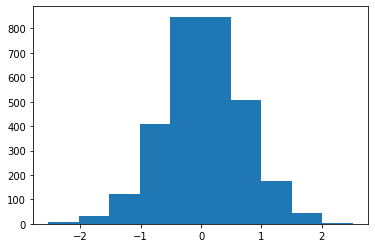

In [30]:
#shows the range of 
plt.hist(prediction_values)

In [32]:
std=np.std(prediction_values);std

0.6679275202203654

In [ ]:
for stat in ufc_fights.columns:
    print(stat)

In [ ]:
#checking by hand that the accuracy of the manual predictions are the same as the accuracy 
#getting .61 after 100 iterations but .56 after 200 iterations (need longer run)
#.53 after 400 iterations (need longer run)
#.545 for 100 iterations (starting at number 400 so [400:500])
#.62 for 500 iterations (starting at number 500 so [500:1000])
#.607 for 1000 iterations (starting at number 1000 so [1000:2000])
# .58 for 1000 iterations (starting at number 2000 so [2000:3000])


#given by python's model score (around .61 at time of writing... Mar 18 2022)
#takes forever... about 3 seconds per computation
real_values = ufc_fights['result']
is_model_correct=[]
index=0
for i in ufc_fights.index[:10]:
    try:
        index+=1
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        if (manual_prediction(f1,f2,date,date)):
            my_pred = 'W'
        else:
            my_pred = 'L'
        print(f1,f2,my_pred,str(real_values[i]))
        if (my_pred==real_values[i]):
            is_model_correct.append(1)
        else:
            is_model_correct.append(0)
    except:
        continue
    if index>0 and index%10==0:
        manual_accuracy = sum(is_model_correct)/len(is_model_correct)
        print('The accuracy of the model is computed as: '+str(manual_accuracy)+' after '+str(index)+' iterations')
        
        

In [ ]:
#making sure the manual model predictions are as expected
#takes forever... about 3 seconds per computation
real_values = ufc_fights['result']
is_model_correct=[]

for i in ufc_fights.index[:10]:
    try:
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        ufc_predict(f1,f2,date,date)
    except:
        print('this fight didnt compute right')

In [ ]:
manual_prediction('Thiago Santos','Magomed Ankalaev', 'March 12, 2022', 'March 12, 2022')

In [ ]:
ufc_predict('Magomed Ankalaev', 'Thiago Santos','March 12, 2022', 'March 12, 2022')

In [ ]:
#checking the distribution of the average absolute values of presigmoid values
#this tells us the thresholds for approximating odds (wins out of 10)
#this takes super long... about 3 seconds per computation
#found best bins to be 0, .2, .4, .6, .8, 1, etc going as 5 6 7 8 9 10 times out of 10
prediction_average_absolute_values=[]
for i in ufc_fights_winner.index[:10]:
    try:
        f1 = ufc_fights['fighter'][i]
        f2 = ufc_fights['opponent'][i]
        date = ufc_fights['date'][i]
        value1 = presigmoid_value(f1,f2,date,date)
        value2 = presigmoid_value(f2,f1,date,date)
        prediction_average_absolute_values.append((abs(value1)+abs(value2))/2)
    except:
        continue

In [ ]:
bins_for_absavg=[]
for i in range(35):
    bins_for_absavg.append(i/25)
plt.hist(prediction_average_absolute_values, bins=bins_for_absavg)

In [ ]:
def give_odds(fighter1,fighter2,date1,date2):
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    if value-value2>=0:
        winner=fighter1
    else:
        winner=fighter2
    value2 = presigmoid_value(fighter2,fighter1,date2,date1)
    abs_value = (abs(value)+abs(value2))/2
    if abs_value >=0 and abs_value <=.2:
        print(winner+" wins a little over 5 times out of 10 times.")
    elif abs_value >=.2 and abs_value <=.4:
        print(winner+" wins 6 out of 10 times.")
    elif abs_value >=.4 and abs_value <=.6:
        print(winner+" wins 7 out of 10 times.")
    elif abs_value >=.6 and abs_value <=.8:
        print(winner+" wins 9 out of 10 times.")
    elif abs_value >=.8:
        print(winner+" wins 10 out of 10 times.")

In [ ]:
def money_line_odds(fighter1,fighter2,date1,date2):
    
    value = presigmoid_value(fighter1,fighter2,date1,date2)
    if value>=0:
        winner=fighter1
    else:
        winner=fighter2
    abs_value = abs(value)
    if abs_value >=0 and abs_value <=.2:
        print(winner+" wins a little over 5 times out of 10 times.")
    elif abs_value >=.2 and abs_value <=.4:
        print(winner+" wins 6 out of 10 times.")
    elif abs_value >=.4 and abs_value <=.6:
        print(winner+" wins 7 out of 10 times.")
    elif abs_value >=.6 and abs_value <=.8:
        print(winner+" wins 9 out of 10 times.")
    elif abs_value >=.8:
        print(winner+" wins 10 out of 10 times.")

In [ ]:
winPredictionModel.intercept_[0]

In [ ]:
#example of finding pre sigmoid value for a fight
b = winPredictionModel.intercept_[0]
value = 0
tup = ufc_prediction_tuple('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')
for i in range(len(tup)):
    value += tup[i]*theta[0][i]
value+b

In [ ]:
give_odds('Colby Covington', 'Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

In [ ]:
#something is serisouly wrong with the model if colby vs jorge gets .126 and jorge vs colby gets -.855
#this needs to be fixed...
v1=presigmoid_value('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')
v2=presigmoid_value('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')
print(v1)
print(v2)
print(abs(v1)+abs(v2)/2)

In [ ]:
presigmoid_value('Jorge Masvidal','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Colby Covington', 'Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Conor McGregor','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Khabib Nurmagomedov','Conor McGregor', 'March 5, 2017', 'March 5, 2017')

In [ ]:
presigmoid_value('Conor McGregor', 'Khabib Nurmagomedov','March 5, 2017', 'March 5, 2017')

In [ ]:
ufc_predict('Colby Covington','Jorge Masvidal', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Rafael Dos Anjos','Renato Moicano', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Renato Moicano','Rafael Dos Anjos', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Edson Barboza','Bryce Mitchell', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Bryce Mitchell', 'Edson Barboza', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Kevin Holland','Alex Oliveira', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
presigmoid_value('Alex Oliveira', 'Kevin Holland','March 5, 2022', 'March 5, 2022',)

In [ ]:
#there must be an issue with the say Spivak's name is scraped. look into this... fix needed
ufc_predict('Sergey Spivak','Greg Hardy', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Jalin Turner','Jamie Mullarkey', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
fighter_height('Yan Xiaonan')

In [ ]:
#issue with unknown reach/height... fix needed
ufc_predict('Marina Rodriguez','Yan Xiaonan', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Nicolae Negumereanu','Kennedy Nzechukwu', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Maryna Moroz','Mariya Agapova', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Umar Nurmagomedov','Brian Kelleher', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Tim Elliott','Tagir Ulanbekov', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
#Must be an issue with michal's name in scraping
ufc_predict('Dustin Jacoby','Michał Oleksiejczuk', 'March 5, 2022', 'March 5, 2022',)

In [ ]:
ufc_predict('Thiago Santos','Magomed Ankalaev', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Marlon Moraes','Song Yadong', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Sodiq Yusuff','Alex Caceres', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Khalil Rountree Jr.','Karl Roberson', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Drew Dober','Terrance McKinney', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Alex Pereira','Bruno Silva', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Matthew Semelsberger','AJ Fletcher', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('JJ Aldrich','Gillian Robertson', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Trevin Jones','Javid Basharat', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Damon Jackson','Kamuela Kirk', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Sabina Mazo','Miranda Maverick', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Dalcha Lungiambula','Cody Brundage', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Kris Moutinho','Guido Cannetti', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict('Tafon Nchukwi','Azamat Murzakanov', 'March 12, 2022', 'March 12, 2022',)

In [ ]:
ufc_predict(ufc_fights['fighter'][i],ufc_fights['opponent'][i],ufc_fights['date'][i],ufc_fights['date'][i])

In [ ]:
ufc_predict('Alexander Volkov','Tom Aspinall','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Arnold Allen','Dan Hooker','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Paddy Pimblett','Rodrigo Vargas','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Gunnar Nelson','Takashi Sato','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Molly McCann','Luana Carolina','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Jai Herbert','Ilia Topuria','March 19, 2022','March 19, 2022')

In [ ]:
ufc_predict('Mike Grundy', 'Makwan Amirkhani', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Shamil Abdurakhimov', 'Sergei Pavlovich', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Nikita Krylov', 'Paul Craig', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Jack Shore', 'Timur Valiev', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Cory McKenna', 'Elise Reed', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Nathaniel Wood', 'Vince Morales', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Muhammad Mokaev', 'Cody Durden', 'March 19, 2022', 'March 19, 2022')

In [ ]:
ufc_predict('Cody Garbrandt','Raphael Assuncao', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Jon Jones','Jon Jones', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Francis Ngannou','Francis Ngannou', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Randy Couture','Francis Ngannou', 'March 5, 2012', 'March 5, 2022')

In [ ]:
ufc_predict('Roy Nelson','Anthony Johnson', 'March 5, 2012', 'March 5, 2022')

In [ ]:
ufc_prediction_tuple('Khabib Nurmagomedov','Colby Covington', 'March 1, 2022', 'March 1, 2022')

In [ ]:
fighter_reach('Conor McGregor')

In [ ]:
fighter_reach('Colby Covington')

In [ ]:
ufc_predict('Colby Covington','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [ ]:
ufc_predict('Khabib Nurmagomedov','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
give_odds('Khabib Nurmagomedov','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
give_odds('Colby Covington','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Khabib Nurmagomedov','Colby Covington', 'March 5, 2022', 'March 5, 2022')

In [ ]:
presigmoid_value('Colby Covington','Khabib Nurmagomedov', 'March 5, 2022', 'March 5, 2022')

In [ ]:
theta[0]

In [ ]:
import json

theta_values = list(theta[0])
jsonStr = json.dumps(theta_values)
print(jsonStr)

In [ ]:
import json
with open('theta.json', 'w') as outfile:
    json.dump(list(theta[0]), outfile)

In [ ]:
b

In [ ]:
import json
with open('intercept.json', 'w') as outfile:
    json.dump(b, outfile)

In [ ]:
nums=[1,2,3,4]

In [ ]:
[[n,k,l] for n,k,l in nums]

In [ ]:
not (1 in [1,2])

In [ ]:
def threeSum(nums):
    from itertools import combinations
    triples = [trip for trip in list(combinations(range(len(nums)), 3)) if trip[0]<trip[1]<trip[2]]
    overcount = [[nums[trip[0]],nums[trip[1]],nums[trip[2]]] for trip in triples if (nums[trip[0]]+nums[trip[1]]+nums[trip[2]]==0)]
    finalcount = [overcount[i] for i in range(len(overcount)) if not (set(overcount[i]) in [set(overcount[j]) for j in range(i)])]
    return finalcount

In [ ]:
threeSum([-1,0,1,2,-1,-4])

In [ ]:
threeSum([0,7,-4,-7,0,14,-6,-4,-12,11,4,9,7,4,-10,8,10,5,4,14,6,0,-9,5,6,6,-11,1,-8,-1,2,-1,13,5,-1,-2,4,9,9,-1,-3,-1,-7,11,10,-2,-4,5,10,-15,-4,-6,-8,2,14,13,-7,11,-9,-8,-13,0,-1,-15,-10,13,-2,1,-1,-15,7,3,-9,7,-1,-14,-10,2,6,8,-6,-12,-13,1,-3,8,-9,-2,4,-2,-3,6,5,11,6,11,10,12,-11,-14])

In [ ]:
nums=[2,0,5,-2,3,-5]
nums.sort()
nums

In [ ]:
from itertools import combinations
triples = [trip for trip in list(combinations(range(len(nums)), 3)) if trip[0]<trip[1]<trip[2] and nums[trip[0]]<0]
triples

In [ ]:
bin_num = '{:032b}'.format(100)

In [ ]:
bin_num

In [ ]:
sum([int(bin_num[i]) for i in range(len(bin_num))])

In [ ]:
range(2,5)[0]

In [ ]:
range(6,2,-1)[0]

In [ ]:
range(6,-1,-1)[-1]

In [ ]:
nums=[1,2,1]
nums.sort()
for k in range(len(nums)-1,1,-1):
    for i in range(k-2,-1,-1):
        for j in range(k-1,i,-1):
            print(i,j,k)
            print(nums[i],nums[j],nums[k])
            if nums[i]+nums[j]>nums[k]:
                print(nums[i]+nums[j]>nums[k])


In [ ]:
pt=[1,2]
pt[1]+=1
pt

In [ ]:
list('abc')

In [ ]:
nums=[1,2,3,4,5,6,7,8]
nums[1:1+3+1]

In [ ]:
range(2,2+3+1)[0]

In [ ]:
range(0)[0]

In [ ]:
for i,x in enumerate([5,4,3,2,1]):
    print(i,x)

In [ ]:
def containsNearbyDuplicate(nums,k):
    hash_map = {}
    for i, num in enumerate(nums):
        if num in hash_map and i - hash_map[num] <= k:
            return True
        else:
            hash_map[num] = i
    return False

In [ ]:
nums=[9,8,7,6,5]
k=4
containsNearbyDuplicate(nums,k)

In [ ]:
def containsNearbyDuplicate(nums,k):
    d = {}
    for i in nums:
        if i in d and i - d[i] <= k:
            return True
        else:
            d[i] = i
    return False

In [ ]:
nums=[1,2,3,4,5,6,7,8,5,4]
k=2
containsNearbyDuplicate(nums,k)

In [ ]:
nums=[1]
sums=[]
for i in range(len(nums)):
    for j in range(i,len(nums)+1):
        sums.append(sum(nums[i:j]))
sums

In [ ]:
nums[0:1]

In [ ]:
string=''
string.
string

In [ ]:
strs=['flower','flow','flour']
common=''
while True:
    if len(set([s[0] for s in strs]))==1:
        common+=strs[0][0]
        print(strs[0][0])
        strs=[string[1:] for string in strs]
    else:
        break
common